In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# #ignore warning messages 
# import warnings
# warnings.filterwarnings('ignore') 

sns.set()

datasetPath = '../data/CURATED/dataset/alphabet-dataset/handwritten-data.csv'

In [3]:
dataset = pd.read_csv(datasetPath).astype('float32')
dataset.rename(columns={'0':'label'}, inplace=True)

# Split data the X - Our data , and y - the prdict label
X = dataset.drop('label', axis = 1)
y = dataset['label']

In [4]:
print("shape:",X.shape)
print("culoms count:",len(X.iloc[1]))
print("784 = 28X28")

X.head()

shape: (372450, 784)
culoms count: 784
784 = 28X28


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
from sklearn.utils import shuffle

X_shuffle = shuffle(X)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle.iloc[i].values.reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

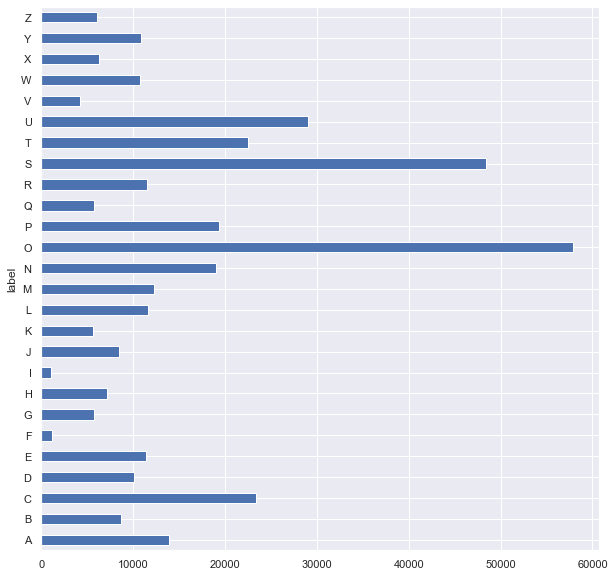

We have very low observations for I and F 
I count: 1120
F count: 1163


In [64]:

# Change label to alphabets
alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 
dataset_alphabets = dataset.copy()
dataset['label'] = dataset['label'].map(alphabets_mapper)

label_size = dataset.groupby('label').size()
label_size.plot.barh(figsize=(10,10))
plt.show()

print("We have very low observations for I and F ")
print("I count:", label_size['I'])
print("F count:", label_size['F'])

In [65]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

Data after scaler


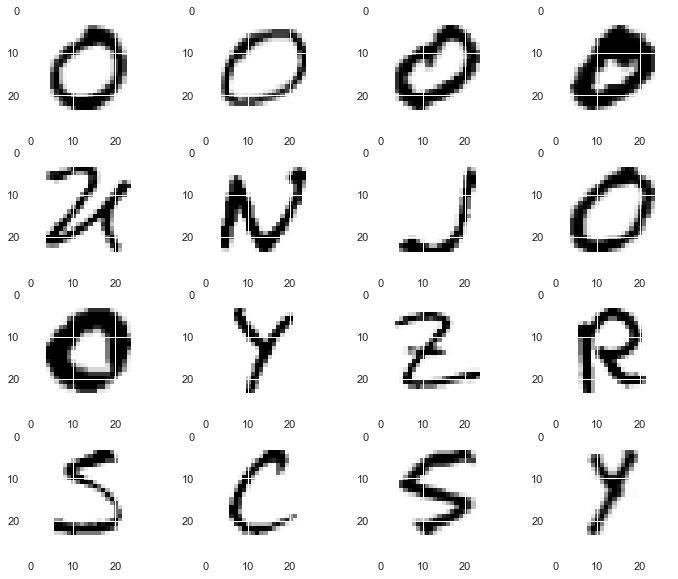

In [66]:
print("Data after scaler")
X_shuffle = shuffle(X_train)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle[i].reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [20]:
cls = Sequential()
cls.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
cls.add(MaxPooling2D(pool_size=(2, 2)))
cls.add(Dropout(0.3))
cls.add(Flatten())
cls.add(Dense(128, activation='relu'))
cls.add(Dense(len(y.unique()), activation='softmax'))

cls.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = cls.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=18, batch_size=200, verbose=2)

scores = cls.evaluate(X_test,y_test, verbose=0)
print("CNN Score:",scores[1])
cls.save('model.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 279337 samples, validate on 93113 samples
Epoch 1/18
279337/279337 - 476s - loss: 0.2224 - acc: 0.9383 - val_loss: 0.0898 - val_acc: 0.9759
Epoch 2/18
279337/279337 - 415s - loss: 0.0839 - acc: 0.9764 - val_loss: 0.0737 - val_acc: 0.9803
Epoch 3/18
279337/279337 - 392s - loss: 0.0642 - acc: 0.9817 - val_loss: 0.0741 - val_acc: 0.9794
Epoch 4/18
279337/279337 - 401s - loss: 0.0524 - acc: 0.9846 - val_loss: 0.0534 - val_acc: 0.9858
Epoch 5/18
279337/279337 - 384s - loss: 0.0436 - acc: 0.9869 - val_loss: 0.0468 - val_acc: 0.9879
Epoch 6/18
279337/279337 - 354s - loss: 0.0374 - acc: 0.9889 - val_loss: 0.0441 - val_acc: 0.9889
Epoch 7/18
279337/279337 - 360s - loss: 0.0319 - acc: 0.9900 - val_loss: 0.0426 - val_acc: 0.9902
Epoch 8/18
279337/279337 - 354s - loss: 0.0267 - acc: 0.9915 - val_loss: 0.0416 - val_acc: 0.9901
Epoch 9/18
279337/279337 - 356s - loss: 0.0238 - acc: 0.9922 - val_loss: 0.0403 - va

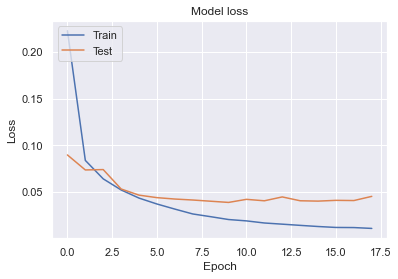

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<AxesSubplot:>

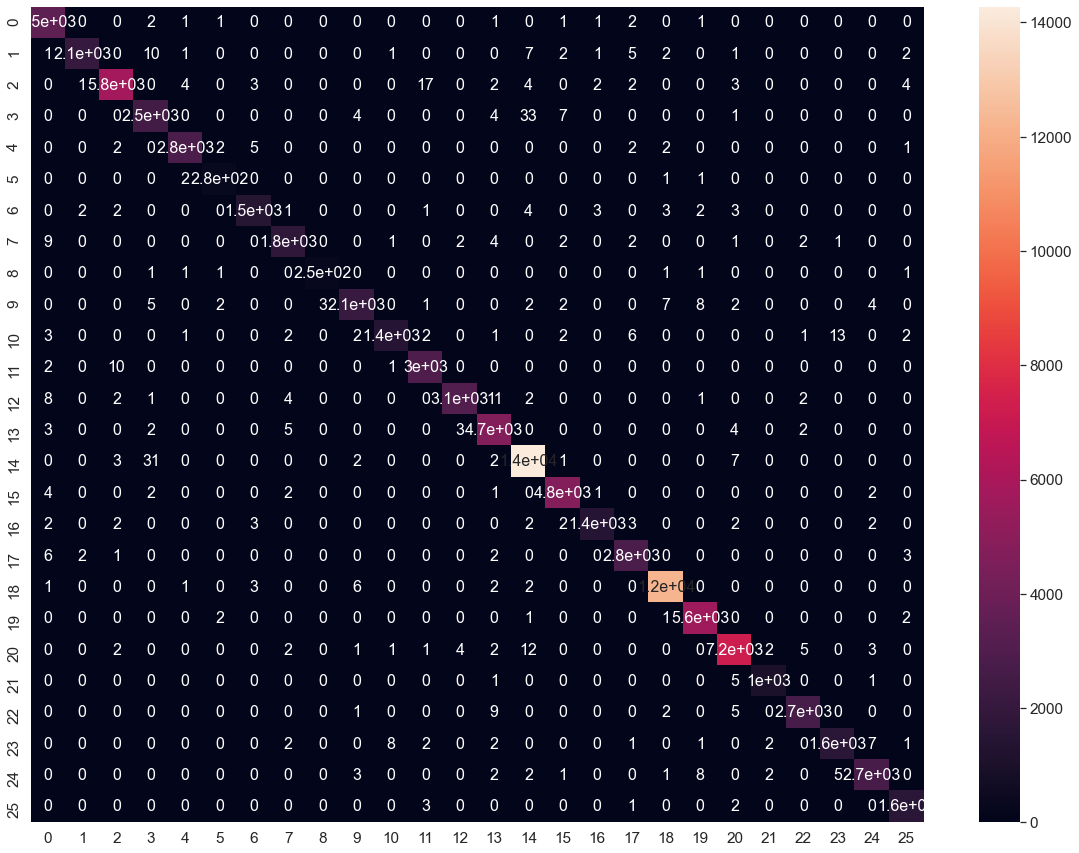

In [22]:
cm=confusion_matrix(y_test.argmax(axis=1),cls.predict(X_test).argmax(axis=1))
df_cm = pd.DataFrame(cm, range(26),
                  range(26))
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size

In [22]:
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (28, 28, 1))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

# img = load('../data/RAW/D.png')
img = load('../data/CURATED/dataset/alphabet-dataset/W/W-46.png')
model = load_model('my_model.h5')
classes = model.predict_classes(img)

alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 

print(alphabets_mapper[classes[0]])

W
